In [1]:
import torch
from mobilevit import MobileViT

model = MobileViT(arch='x_small').cuda()
state_dict = torch.load('/root/palmprint/x_small_model_weights_best.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [2]:
# load validation set
with open('/root/autodl-tmp/verification/ROI/validation.txt') as f:
    lines = f.readlines()

images = [line.rstrip('\n') for line in lines]

# sort images based on their labels
sorted_images = sorted(images, key=lambda s : (int(s[:3]), s[8]))

labels = [(int(img[:3])-1) * 2 + int(img[8] == 'r') for img in sorted_images]

In [3]:
import os
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PalmValidationDataset(Dataset):
    def __init__(self, img_dir: str, img_list: list, transform=None):
        super(PalmValidationDataset, self).__init__()
        self.img_dir = img_dir
        self.images = img_list
        # self.labels = label_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        image = Image.open(img_path)
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = PalmValidationDataset(img_dir='/root/autodl-tmp/verification/ROI',
                                img_list=sorted_images,
                                transform=transform)

bs = 400
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=12)

feat_mat = torch.zeros(1600, 384).cuda()  # (num_img, dim_feat)

for idx, image in enumerate(dataloader):
    image = image.cuda()
    with torch.no_grad():
        features = model(image)
        features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        norm_feat = (features**2).sum(axis=1, keepdim=True).sqrt()
        features = features / norm_feat
        feat_mat[idx * bs : (idx + 1) * bs, :] = features


In [6]:
feat_mat

tensor([[ 0.0847,  0.0319, -0.0364,  ...,  0.0809,  0.0245,  0.1207],
        [ 0.0448,  0.0290, -0.0205,  ...,  0.1005,  0.0503,  0.1356],
        [ 0.0516,  0.0285, -0.0302,  ...,  0.0921,  0.0349,  0.1461],
        ...,
        [ 0.0100,  0.0438, -0.0445,  ..., -0.0408,  0.0471, -0.0220],
        [ 0.0339,  0.0153, -0.0403,  ...,  0.0915,  0.0871, -0.0122],
        [-0.0142,  0.0181, -0.0289,  ...,  0.0581,  0.1137, -0.0512]],
       device='cuda:0')

In [7]:
# simlilarity matrix
sim_mat = feat_mat @ feat_mat.T

In [8]:
sim_mat

tensor([[ 1.0000e+00,  9.4389e-01,  9.3690e-01,  ..., -4.8209e-03,
          2.4808e-01,  1.0811e-01],
        [ 9.4389e-01,  1.0000e+00,  9.8108e-01,  ..., -4.7749e-04,
          2.1619e-01,  1.1464e-01],
        [ 9.3690e-01,  9.8108e-01,  1.0000e+00,  ...,  3.1007e-02,
          1.9055e-01,  1.2054e-01],
        ...,
        [-4.8209e-03, -4.7749e-04,  3.1007e-02,  ...,  1.0000e+00,
          4.7567e-01,  4.8830e-01],
        [ 2.4808e-01,  2.1619e-01,  1.9055e-01,  ...,  4.7567e-01,
          1.0000e+00,  7.6573e-01],
        [ 1.0811e-01,  1.1464e-01,  1.2054e-01,  ...,  4.8830e-01,
          7.6573e-01,  1.0000e+00]], device='cuda:0')

In [9]:
# ground truth matrix
gt = torch.zeros(1600, 1600, dtype=int).cuda()
for i in range(40):
    gt[i * 40 : (i + 1) * 40, i * 40 : (i + 1) * 40] = 1

In [10]:
gt

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')

In [25]:
# test threshold
acc_list = []
far_list = []    # false acceptance rate
tpr_list = []    # true positive rate

t = 0
while t < 1:
    predict = sim_mat > t
    correct = predict == gt
    num_true_positive = (predict * gt).sum()
    num_false_positive = (predict * (1 - gt)).sum()
    acc = correct.sum() / (1600 * 1600)
    tpr = num_true_positive / (40 * 40 * 40)
    far = num_false_positive / (1600 * 1600 - 40 * 40 * 40)
    print(f't = {t:.3f}, acc = {acc:.4f}, tpr = {tpr:.4f}, far = {far:.4f}')
    acc_list.append(acc)
    far_list.append(far)
    tpr_list.append(tpr)
    t += 0.01

t = 0, acc = 0.183115616440773, tpr = 0.9990313053131104, far = 0.8378052711486816
t = 0.01, acc = 0.2052132785320282, tpr = 0.9984375238418579, far = 0.8151258230209351
t = 0.02, acc = 0.22873671352863312, tpr = 0.9978438019752502, far = 0.7909839749336243
t = 0.03, acc = 0.2539624869823456, tpr = 0.9970937967300415, far = 0.765092134475708
t = 0.04, acc = 0.2802836000919342, tpr = 0.9960938096046448, far = 0.7380704879760742
t = 0.05, acc = 0.3082476556301117, tpr = 0.994937539100647, far = 0.7093597650527954
t = 0.060000000000000005, acc = 0.3373984396457672, tpr = 0.9938125610351562, far = 0.6794326901435852
t = 0.07, acc = 0.367403119802475, tpr = 0.9925000667572021, far = 0.6486250162124634
t = 0.08, acc = 0.3979218602180481, tpr = 0.990531325340271, far = 0.617273211479187
t = 0.09, acc = 0.42879998683929443, tpr = 0.9881563186645508, far = 0.5855425000190735
t = 0.09999999999999999, acc = 0.46018436551094055, tpr = 0.9855937957763672, far = 0.55328768491745
t = 0.10999999999999

In [12]:
# test threshold
acc_list = []
far_list = []    # false acceptance rate
tpr_list = []    # true positive rate

t = 0
while t < 1:
    predict = sim_mat > t
    correct = predict == gt
    num_true_positive = (predict * gt).sum()
    num_false_positive = (predict * (1 - gt)).sum()
    acc = correct.sum() / (1600 * 1600)
    tpr = num_true_positive / (40 * 40 * 40)
    far = num_false_positive / (1600 * 1600 - 40 * 40 * 40)
    print(f't = {t:.3f}, acc = {acc:.4f}, tpr = {tpr:.4f}, far = {far:.5f}')
    acc_list.append(acc)
    far_list.append(far)
    tpr_list.append(tpr)
    t += 0.01

t = 0.000, acc = 0.5431, tpr = 0.9930, far = 0.46847
t = 0.010, acc = 0.5671, tpr = 0.9916, far = 0.44374
t = 0.020, acc = 0.5910, tpr = 0.9902, far = 0.41927
t = 0.030, acc = 0.6141, tpr = 0.9892, far = 0.39552
t = 0.040, acc = 0.6368, tpr = 0.9878, far = 0.37221
t = 0.050, acc = 0.6589, tpr = 0.9863, far = 0.34954
t = 0.060, acc = 0.6803, tpr = 0.9846, far = 0.32750
t = 0.070, acc = 0.7011, tpr = 0.9826, far = 0.30612
t = 0.080, acc = 0.7212, tpr = 0.9808, far = 0.28548
t = 0.090, acc = 0.7403, tpr = 0.9787, far = 0.26577
t = 0.100, acc = 0.7587, tpr = 0.9757, far = 0.24684
t = 0.110, acc = 0.7763, tpr = 0.9735, far = 0.22873
t = 0.120, acc = 0.7933, tpr = 0.9706, far = 0.21123
t = 0.130, acc = 0.8091, tpr = 0.9670, far = 0.19490
t = 0.140, acc = 0.8243, tpr = 0.9631, far = 0.17929
t = 0.150, acc = 0.8385, tpr = 0.9587, far = 0.16456
t = 0.160, acc = 0.8518, tpr = 0.9544, far = 0.15081
t = 0.170, acc = 0.8641, tpr = 0.9498, far = 0.13804
t = 0.180, acc = 0.8758, tpr = 0.9440, far = 0

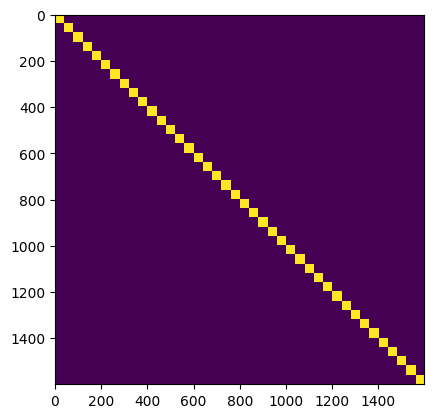

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(gt.cpu().numpy(), cmap='viridis', interpolation='nearest')

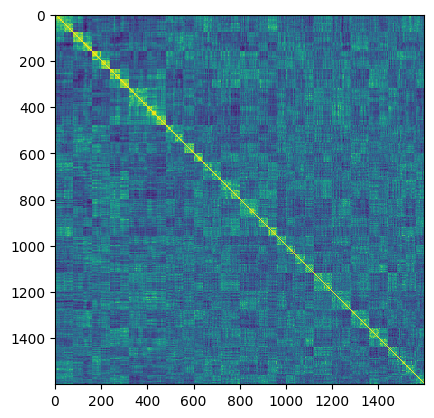

In [14]:
plt.imshow(sim_mat.cpu().numpy(), cmap='viridis', interpolation='nearest')

In [17]:
from torchsummary import summary

summary(model, (3, 256, 256))

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f313ab20280>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 1, 3, 256, 256]